In [ ]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D as Conv2D, MaxPooling2D
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras import backend as K
from keras import losses
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_absolute_error
from PIL import Image

In [ ]:
def read_images(path,num_images,xdim,ydim):
    images = []
    all_paths = os.listdir(path)
    mini_set = all_paths[:num_images]
    for i in mini_set:
        file = path+"/"+i
        image = cv2.imread(file)
        image = cv2.resize(image,(xdim,ydim))
        images.append(image)

    return images

#funkcija za pretvaranje rgb u  lab 
def rgb_to_lab(images):
    lab_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
        lab_images.append(lab_image)

    return lab_images

def lab_to_rgb(images):
    rgb_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_LAB2RGB)
        lab_images.append(lab_image)

#funkcija za izdvajanje l kanala i ab za trening 
def extract_channels(lab_images):
    l_channels = []
    a_channels = []
    b_channels = []
    for i in lab_images:
        l,a,b = cv2.split(i)
        l_channels.append(l)
        a_channels.append(a)
        b_channels.append(b)

    return np.array(l_channels), np.array(a_channels), np.array(b_channels)

#funkcija za stvaranje podataka za treniranje i testiranje
def create_train_data(l,a,b):
    train_data = []
    for i in l:
        train_data.append(np.array(i,dtype= 'float32'))
    train_labels_a = []
    train_labels_b = []
    for i in a:
        train_labels_a.append(np.array(i.flatten(),dtype='float32'))
    for i in b:
        train_labels_b.append(np.array(i.flatten(),dtype='float32'))
    train_labels = []
    for i,j in zip(train_labels_a,train_labels_b):
        train_labels.append(np.concatenate((i,j),axis = 0))
    
    return train_data, train_labels

In [ ]:
!rm -rf clone && git clone https://github.com/Bileth/Grayscale-image-colorization clone && cp -a clone/. .

Cloning into 'clone'...
remote: Enumerating objects: 15126, done.
remote: Counting objects: 100% (875/875), done.
remote: Compressing objects: 100% (843/843), done.
remote: Total 15126 (delta 30), reused 866 (delta 24), pack-reused 14251
Receiving objects: 100% (15126/15126), 788.43 MiB | 29.19 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (22429/22429), done.


In [ ]:
path = "train/images/color"  
num_images = 7000  
x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim)
lab_images = rgb_to_lab(images)
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [ ]:
print(len(images))

7000


In [ ]:
print(len(train_data))

7000


In [ ]:
train_data = np.reshape(train_data,(num_images,x_dim,y_dim,1))
train_data.shape[3]
train_labels = np.reshape(train_labels,(num_images,128*128*2))

In [ ]:
print(train_data.shape)

(7000, 128, 128, 1)


In [ ]:
img_cols = 128
img_rows = 128
if K.image_data_format() == 'channels_first':
    train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(train_labels.shape[1], activation='linear'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 batch_normalization_26 (Bat  (None, 61, 61, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                      

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(loss='mse',
              optimizer= opt)

In [ ]:
batch_size = 64
epochs = 200
trainedmodel = model.fit(train_data, train_labels, epochs=epochs, validation_split = 0.1)

Epoch 1/200
197/197 [==============================] - 9s 37ms/step - loss: 15998.7559 - val_loss: 14130.2227
Epoch 2/200
197/197 [==============================] - 6s 31ms/step - loss: 9319.4619 - val_loss: 3137.7590
Epoch 3/200
197/197 [==============================] - 6s 32ms/step - loss: 1000.6153 - val_loss: 1325.1292
Epoch 4/200
197/197 [==============================] - 6s 32ms/step - loss: 370.6023 - val_loss: 593.7104
Epoch 5/200
197/197 [==============================] - 6s 31ms/step - loss: 270.7018 - val_loss: 309.5516
Epoch 6/200
197/197 [==============================] - 6s 32ms/step - loss: 237.3978 - val_loss: 643.4411
Epoch 7/200
197/197 [==============================] - 6s 31ms/step - loss: 238.5610 - val_loss: 206.4061
Epoch 8/200
197/197 [==============================] - 6s 31ms/step - loss: 247.0230 - val_loss: 224.8265
Epoch 9/200
197/197 [==============================] - 6s 31ms/step - loss: 224.5335 - val_loss: 175.7054
Epoch 10/200
197/197 [================

In [ ]:
model.save("CNN_colorize.h5")

In [ ]:
model = tf.keras.models.load_model('CNN_colorize.h5')

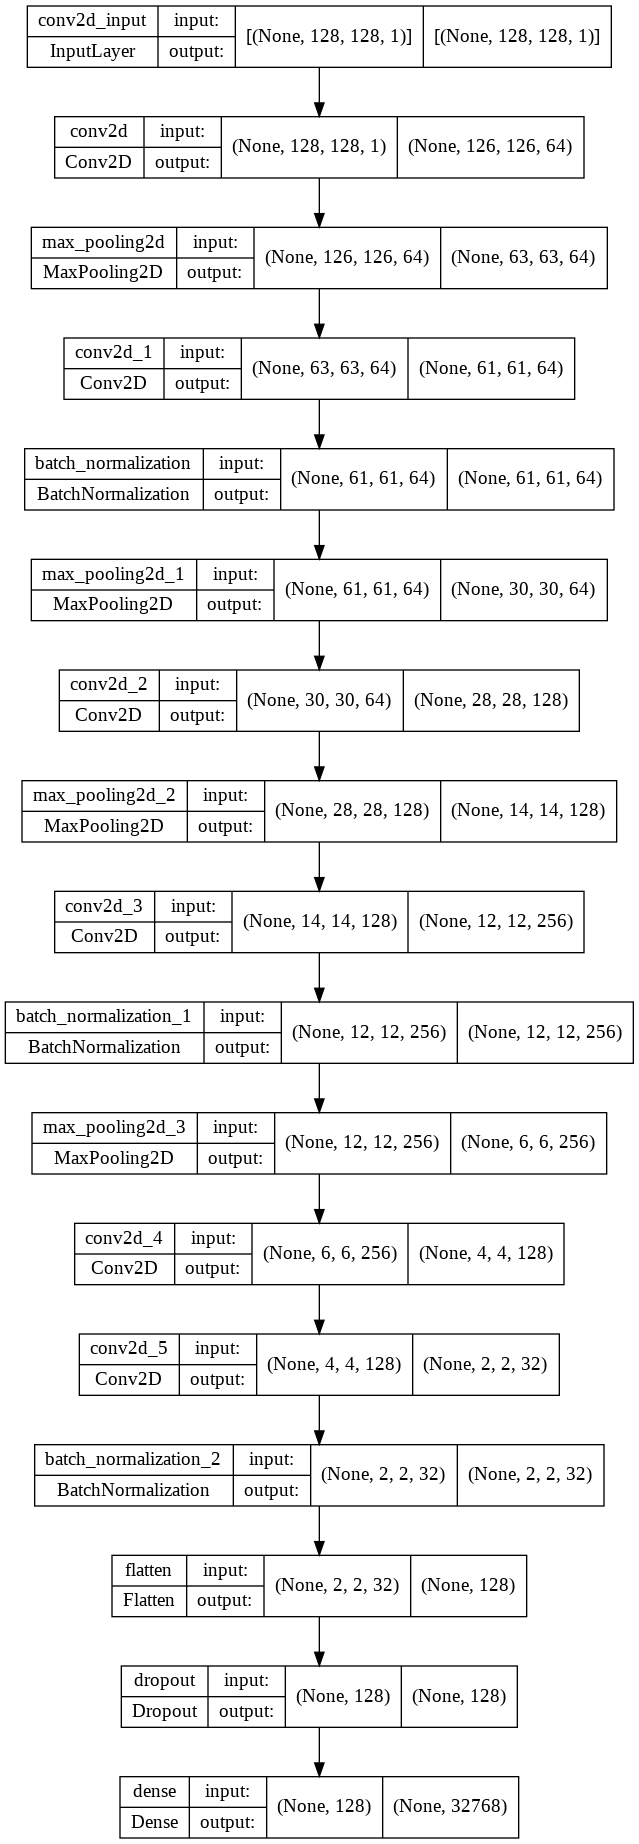

In [ ]:
tf.keras.utils.plot_model(model, 'encoder_compress.png', show_shapes=True)

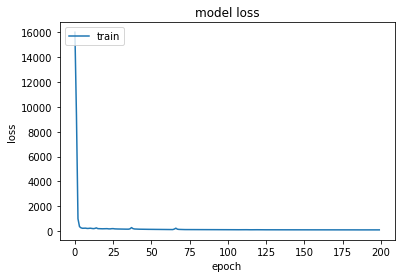

In [ ]:
# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

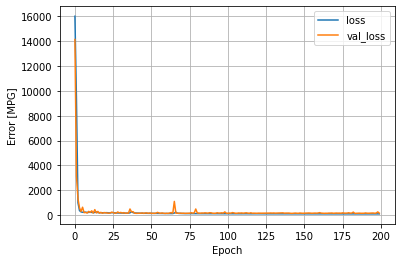

In [ ]:
plot_loss(trainedmodel)

In [ ]:
path = "test/images/gray"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [ ]:
index = 1 #odabir slike
tr = np.reshape(train_data[index],(1,128,128,1)) 
p = model.predict(tr) 

In [ ]:
x = list(p[0])
length = len(p[0])
x1 = x[:int(length/2)] #podjela predviđenog a i b kanala u jednake polovice kako bi ih dobili
x2 = x[int(length/2):]

x1 = np.array(np.reshape(x1,(x_dim,y_dim)),dtype = 'uint8')
x2 = np.array(np.reshape(x2,(x_dim,y_dim)),dtype = 'uint8')

t = np.array(np.reshape(tr,(x_dim,y_dim)),dtype = 'uint8')
pred = cv2.merge((t,x1,x2)) #spajanje L kanala sa a i b kanalima kako bi dobili obojanu sliku

In [ ]:
path = "test/images/color"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
actual, actual_labels = create_train_data(l,a,b)

In [ ]:
path = "CNN_results"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
predicted, predicted_labels = create_train_data(l,a,b)

In [ ]:
master_dir = 'evaluacijski_test/gray/'

In [ ]:
x = []

In [ ]:
for image_file in os.listdir( master_dir ):
    gray_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( 120 , 120 ) )
    gray_img_array = ( np.asarray( gray_image ).reshape( ( 120 , 120 , 1 ) ) ) / 255
    x.append( gray_img_array )

In [ ]:
path = "evaluacijski_test/gray/"
num_images = 100

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
tests_data, tests_labels = create_train_data(l,a,b)

In [ ]:
CNN_differences = []

In [ ]:
print(len(x))

32768


In [ ]:
for index in range(num_images): 
  tr = np.reshape(train_data[index], (1,128,128,1)) 
  p = CNN_model.predict(tr) 
  x = list(p[0])
  length = len(p[0])
  x1 = x[:int(length/2)] #podjela predviđenog a i b kanala u jednake polovice kako bi ih dobili
  x2 = x[int(length/2):]

  x1 = np.array(np.reshape(x1,(x_dim,y_dim)),dtype = 'uint8')
  x2 = np.array(np.reshape(x2,(x_dim,y_dim)),dtype = 'uint8')

  t = np.array(np.reshape(tr,(x_dim,y_dim)),dtype = 'uint8')
  pred = cv2.merge((t,x1,x2)) #spajanje L kanala sa a i b kanalima kako bi dobili obojanu sliku
  pred = cv2.cvtColor(pred, cv2.COLOR_LAB2RGB);

  cv2.imwrite(str(index)+'.png', pred)

IndexError: ignored

In [ ]:
new_dir = ''

In [ ]:
for i in range(num_images): 
  image2 = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 120 , 120 ) )
  CNN_rez = Image.open( os.path.join( new_dir , 'image'+ str(i) +'.png' ) ).resize( ( 120 , 120 ) )
  CNN_differences.append(np.square(np.subtract(image2, CNN_rez)).mean())

In [ ]:
plt.plot(CNN_differences)
plt.xlabel('Slike') 
plt.ylabel('MSE') 
plt.title("Graf pogreške nad testnim skupom")
plt.show()

In [ ]:
print(np.mean(CNN_differences))